In [73]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler


from patchify import patchify

In [130]:
data_dir = 'Semantic_segmentation_dataset/'
scaler = MinMaxScaler()
patch_size = 256
images = []
masks = []

In [131]:
def load_patch_images(data_dir):
    image_dataset = []
    for path, subdirs, files in os.walk(data_dir):

        directory_name = path.split(os.path.sep)[-1]
        if directory_name == 'images':
            images = os.listdir(path)
            for i, image_name in enumerate(images):  
                if image_name.endswith(".jpg"):
                
                    image = cv2.imread(path+"/"+image_name, 1)
                    X_shape = (image.shape[1]//patch_size)*patch_size
                    Y_shape = (image.shape[0]//patch_size)*patch_size

                    image = Image.fromarray(image)
                    image = image.crop((0 ,0, X_shape, Y_shape))
                    image = np.array(image)

                    patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                    for i in range(patch_img.shape[0]):
                        for j in range(patch_img.shape[1]):
                            single_patch_img = patch_img[i,j,:,:]
                            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)                        
                            single_patch_img = single_patch_img[0]
                            image_dataset.append(single_patch_img)

    return np.array(image_dataset), single_patch_img
                    


In [160]:
#def load_patch_masks(data_dir):
masks_dataset = []
for path, subdirs, files in os.walk(data_dir):

    directory_name = path.split(os.path.sep)[-1]
    if directory_name == 'masks':
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):
            
                image = cv2.imread(path+"/"+image_name, 1)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                X_shape = (image.shape[1]//patch_size)*patch_size
                Y_shape = (image.shape[0]//patch_size)*patch_size

                image = Image.fromarray(image)
                image = image.crop((0 ,0, X_shape, Y_shape))
                image = np.array(image)

                patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patch_img.shape[0]):
                    for j in range(patch_img.shape[1]):
                        single_patch_img = patch_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)                        
                        single_patch_img = single_patch_img[0]
                        masks_dataset.append(single_patch_img)

    #return np.array(image_dataset) , single_patch_img

In [153]:
images , single_patch_img = load_patch_images(data_dir)
images.shape

(1305, 256, 256, 3)

In [166]:
masks = np.array(masks_dataset)
single_patch_mask.shape


(256, 256, 3)

In [135]:
class_dict = pd.read_csv("class.csv", index_col=False, skipinitialspace=True)
class_dict

,name,color
0,Building,#3C1098
1,Land,#8429F6
2,Road,#6EC1E4
3,Vegetation,#FEDD3A
4,Water,#E2A929
5,Unlabeled,#9B9B9B


In [162]:
Building = np.array(tuple(int(class_dict['color'][0].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
Land = np.array(tuple(int(class_dict['color'][1].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
Road = np.array(tuple(int(class_dict['color'][2].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Vegetation = np.array(tuple(int(class_dict['color'][3].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Water = np.array(tuple(int(class_dict['color'][4].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Unlabeled = np.array(tuple(int(class_dict['color'][5].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))


In [169]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155


In [170]:
label = single_patch_mask

In [171]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)

    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]

    return label_seg

In [172]:
labels = []
for i in range(masks.shape[0]):
    label = rgb_to_2D_label(masks[i])
    labels.append(label)

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [173]:
print("Unique labels in label dataset are: ", np.unique(labels))


Unique labels in label dataset are:  [0]


In [146]:
label.shape

(256, 256)

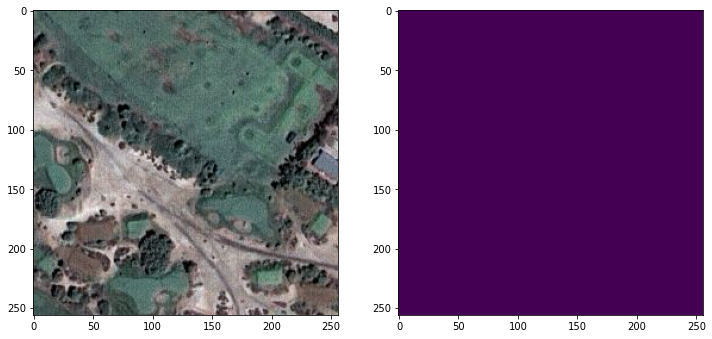

In [143]:
import random
import numpy as np
image_number = random.randint(0, len(images))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(images[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()